# Searching for nearly conserved quantities in FPU chains

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import fpu_hamiltonian
from models import NICE, SymplecticExchange, IrrotationalMLP, LinearSymplecticTwoByTwo, Chain
from utils import visualize_chain_bijector_1d, extract_q_p, join_q_p, is_symplectic, run_eagerly, hamiltonian_traj

In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
tf.set_random_seed(0)

## Look at an FPU trajectory

In [50]:
N = 5
α = 0.2
init_state = tf.random_normal([2*N])
# Need to remove centre of mass motion
qs, ps = init_state[::2], init_state[1::2]
ps = ps - tf.reduce_mean(ps)
qs = tf.expand_dims(qs, axis=-1)
ps = tf.expand_dims(ps, axis=-1)
init_state = tf.concat([qs, ps], axis=1)
init_state = tf.reshape(init_state, shape=[-1])

fpu_traj = hamiltonian_traj(lambda x: fpu_hamiltonian(x, alpha=α), init_state, time=100, steps=10000, rtol=1e-4, atol=1e-4)

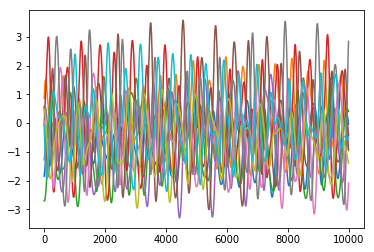

In [51]:
plt.plot(sess.run(fpu_traj))

## Go to normal modes

In [52]:
qs, ps = tf.spectral.rfft(fpu_traj[:,::2]), tf.spectral.rfft(fpu_traj[:,1::2])

In [57]:
q_np, p_np = sess.run([qs, ps])

For `rfft` output is of size $n/2 + 1$, with the first entry being the zero mode

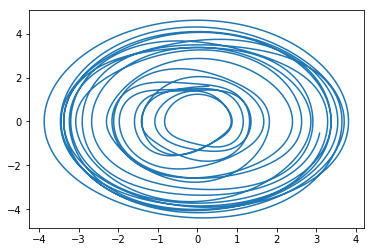

In [58]:
plt.plot(np.real(q_np[:,1]), np.real(p_np[:,1]))

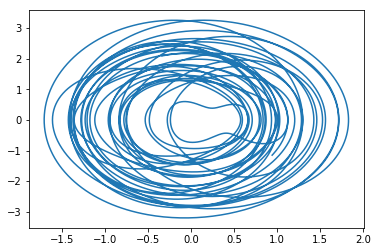

In [59]:
plt.plot(np.imag(q_np[:,2]), np.imag(p_np[:,2]))

We see that for weak nonlinearity we can still see the oscillatory behaviour of normal modes

## Learn a transformation

In [10]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [11]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': (lambda x: fpu_hamiltonian(x, alpha=α)),
    'phase_space_dim': 4*(N//2), # Note that we are going to ignore the zero mode.
    'batch_size': 1024,    # Mini batch size 
    'stack_size': 4}        # How many sets of NICE / SymplecticExchange / LinearSymplecticTwoByTwo

In [12]:
bijectors = []
for _ in range(settings['stack_size']):
    bijectors.extend([SymplecticExchange(),
                      NICE(shift_model=IrrotationalMLP(activation=tf.nn.tanh, width=32)),
                      LinearSymplecticTwoByTwo()])
model = Chain(bijectors)

## Set up the loss

Need to map from the normal mode amplitudes to the real space coordinates. Note the normalization

In [13]:
def modes_to_coords(amps):
    """map the mode amplitudes to coordinates. Shape is [batch_size, 4*(N//2), 1] with 1 axis having format:
    input: [q_r1, p_r1, q_i1, p_i1, ..., p_1(N//2)] for q_r and q_i the real and imaginary amplitudes
    output: [q_1, p_1, .... p_1N]
    
    A zero mode is added with zero amplitude
    """
    amp = tf.to_complex64(amps)
    q_modes, p_modes = extract_q_p(amps)
    complex_q_modes = tf.complex(q_modes[:,::2,0], q_modes[:,1::2,0])
    complex_p_modes = tf.complex(p_modes[:,::2,0], p_modes[:,1::2,0])
    zero_mode = tf.zeros_like(complex_q_modes[:,:1], dtype=tf.complex64)
    complex_q_modes = tf.concat([zero_mode, complex_q_modes], axis=-1)
    complex_p_modes = tf.concat([zero_mode, complex_p_modes], axis=-1)
    # Transform and normalize
    sqrt_length = tf.sqrt(tf.cast(complex_q_modes.shape[-1], dtype=tf.float32))
    q = tf.expand_dims(tf.spectral.irfft(complex_q_modes), axis=-1) * sqrt_length
    p = tf.expand_dims(tf.spectral.irfft(complex_p_modes), axis=-1) * sqrt_length
    return join_q_p(q, p)

In [14]:
with tf.name_scope("loss"):
    base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([settings['phase_space_dim']], DTYPE))
    z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']), -1)
    coords = modes_to_coords(z_samples)
    Hprime = settings['hamiltonian'](model(coords))
    Hprime_grads = tf.gradients(Hprime, z_samples)[0]
    q, p = extract_q_p(z_samples)
    q_grads, p_grads = extract_q_p(Hprime_grads)
    loss = tf.reduce_mean(tf.square(q * p_grads - p * q_grads))

## Train

In [16]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step=step)

In [17]:
tf.summary.scalar("loss_function", tf.reshape(loss, []))

<tf.Tensor 'loss_function:0' shape=() dtype=string>

In [18]:
tf.contrib.training.train(train_op, logdir="../fpu-logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../fpu-logging/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../fpu-logging/model.ckpt.
INFO:tensorflow:global_step/sec: 37.3726
INFO:tensorflow:global_step/sec: 70.3096
INFO:tensorflow:global_step/sec: 66.1801
INFO:tensorflow:global_step/sec: 72.0126
INFO:tensorflow:global_step/sec: 70.7197
INFO:tensorflow:global_step/sec: 72.0417
INFO:tensorflow:global_step/sec: 72.2443
INFO:tensorflow:global_step/sec: 68.3416
INFO:tensorflow:global_step/sec: 68.6329
INFO:tensorflow:global_step/sec: 75.534
INFO:tensorflow:global_step/sec: 75.762
INFO:tensorflow:global_step/sec: 76.0545
INFO:tensorflow:global_step/sec: 73.571
INFO:tensorflow:global_step/sec: 61.1812
INFO:tensorflow:global_step/sec: 59.4986
INFO:tensorflow:global_step/sec: 66.0938
INFO:tensorflow:global_step/sec: 72.7713

KeyboardInterrupt: 

## Look at the learned representation

In [32]:
traindir = "../fpu-logging"
saver = tf.train.Saver()

ckpt_state = tf.train.get_checkpoint_state(traindir)
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../fpu-logging/model.ckpt-4086


In [39]:
tf.spectral.rfft?

In [33]:
def coords_to_modes(coords):
    qs, ps = extract_q_p(coords)
    qs = tf.squeeze(qs) # Eliminate the final axis
    ps = tf.squeeze(ps)
    # Transform and normalize
    sqrt_length = tf.sqrt(tf.cast(qs.shape[-1], dtype=tf.complex64))
    q_modes = tf.spectral.rfft(qs) / sqrt_length
    p_modes = tf.spectral.rfft(ps) / sqrt_length
    q_modes = q_modes[:,1:] # Remove the zero mode
    p_modes = p_modes[:,1:]
    q_modes_r, q_modes_i = tf.real(q_modes), tf.imag(q_modes)
    p_modes_r, p_modes_i = tf.real(p_modes), tf.imag(p_modes)
    q_modes = join_q_p(tf.expand_dims(q_modes_r, axis=-1), tf.expand_dims(q_modes_i, axis=-1))
    p_modes = join_q_p(tf.expand_dims(p_modes_r, axis=-1), tf.expand_dims(p_modes_i, axis=-1))
    amps = join_q_p(q_modes, p_modes)
    return amps

In [34]:
traj_amps = coords_to_modes(tf.expand_dims(fpu_traj, axis=-1))
np_traj_amps = sess.run(traj_amps)

In [35]:
np_trans_amps = sess.run(model.inverse(np_traj_amps))

In [36]:
np_traj_amps = np.transpose(np.reshape(np_traj_amps, (-1,4,2)), (1,2,0))
np_trans_amps = np.transpose(np.reshape(np_trans_amps, (-1,4,2)), (1,2,0))

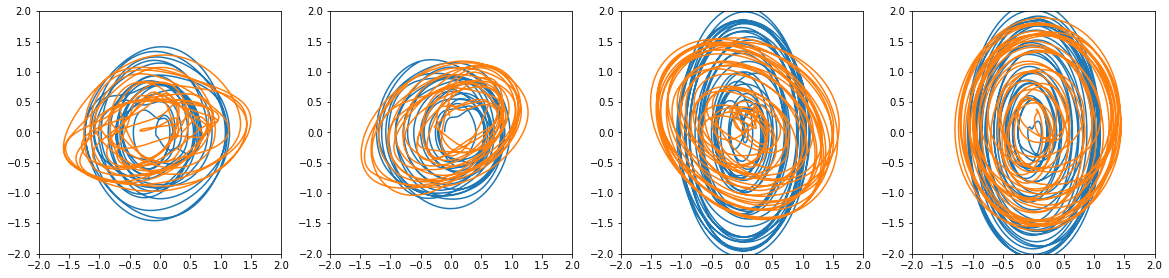

In [37]:
plt.figure(figsize=(20,20))

for idx, mode in enumerate(np_traj_amps):
    plt.subplot(2, 4, idx+1)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    
    plt.plot(mode[0], mode[1])
    plt.plot(np_trans_amps[idx,0], np_trans_amps[idx,1])
    plt.gca().set_aspect('equal', adjustable='box')